# **Import Libraries**

In [7]:
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,f_oneway
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats


# **Step 1: Data Cleaning  And Replace Missing Values**

# **Function to replace "-" into null + calculate the percentage of missing values in each coloumn**

In [8]:
def replace_char_calculate_prc_missing_values(df,numeric_columns):
  numeric_columns = numeric_columns
  # List of all columns
  all_columns = df.columns
  # Identify non-numeric columns
  categorical_columns = [col for col in all_columns if col not in numeric_columns]
  # Replace "-" with NaN in both numerical and categorical columns
  df[numeric_columns] = df[numeric_columns].replace('-', np.nan)
  df[categorical_columns] = df[categorical_columns].replace('-', np.nan)
  # Convert numerical columns to float
  df[numeric_columns] = df[numeric_columns].astype(float)
  #-----------------------------------------------------
  missing_percentage = (df.isnull().sum()/len(df))* 100
  # Create a DataFrame to display the results
  missing_info = pd.DataFrame({
      'Column': missing_percentage.index,
      'Missing Percentage': missing_percentage.values })
  return missing_info.sort_values(by=['Missing Percentage'])

In [9]:
def generate_necessary_columns(list_unecessary_columns,columns):
  neccessary_columns=[ name for name in columns if name not in list_unecessary_columns]
  return neccessary_columns


In [10]:
def Filling_missing_values_by_IQR(df,columns_numbers):
    Q1= df[columns_numbers].quantile(0.25)
    Q3= df[columns_numbers].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define boundaries for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Replace outliers with median
    for column in df.columns:
      if df[column].dtype=='float64' or df[column].dtype=='int64':
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound[column]) | (df[column] > upper_bound[column]),np.nan , df[column])

    return df

In [11]:
def plote_bar_char_with_labels(column,data_frame):
  #understanding the column.
  plt.figure(figsize=(8, 6))  # Set the figure size (optional)
  precent=data_frame[column].value_counts()/data_frame[column].value_counts().sum()
  precent=precent[precent>=0.01]
  precent.plot(kind='bar')
  for index, value in enumerate(precent):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
  plt.title('Probability Graph for {} based on the number of existing values in the column'.format(column))
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent clipping of annotations
  plt.show()


In [12]:
#convert the integers values to Na
def converting_column_integers_to_Na(df,column):
  numeric_mask = pd.to_numeric(df[column], errors='coerce').notnull()
  df.loc[numeric_mask,column]=np.nan
  return df


In [13]:
def choosing_the_K(data):
  copy_data_numeric=data.copy()[data.select_dtypes(include='float64').columns]
  #fill missing values category and floating numbers:
  for col in copy_data_numeric.columns:
     mean_val = copy_data_numeric[col].median()
     copy_data_numeric[col].fillna(mean_val, inplace=True)

  # Step 2: Perform K-means clustering k=10
  inertia_=[]
  for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(copy_data_numeric)
    inertia_.append(kmeans.inertia_)

    #step 3 choosing the k
  plt.plot(range(1,11),inertia_)

In [14]:
def clustering_and_replace_missing_values(df,k,category_to_replace):
 float_columns=df.select_dtypes(include='float64').columns
 category_columns=df.select_dtypes(include='object').columns
 copy_data=df.copy()
 #fill missing values  of floating numbers
 for col in float_columns:
  mean_val = copy_data[col].median()
  copy_data[col].fillna(mean_val, inplace=True)
  # Fill missing values of categorical columns with most frequent value
  for col in category_columns:
    frequent_val = copy_data[col].mode()[0]
    copy_data[col].fillna(frequent_val, inplace=True)
 sc_data=MinMaxScaler()
 sc_data=sc_data.fit_transform(copy_data[float_columns])
 kmeans = KMeans(n_clusters=k)
 kmeans.fit(sc_data)
 clusters= kmeans.labels_

# Step 3: Calculate cluster means
 cluster_means = []
 for i in range(k):
  cluster_data = copy_data[float_columns][clusters == i]
  cluster_mean = np.mean(cluster_data, axis=0)
  cluster_means.append(cluster_mean)

 #Calculate frequent values for categorical columns within each cluster
 cluster_frequent_values_categorical = []
 for i in range(k):
  cluster_data = copy_data[category_to_replace][clusters == i]
  frequent_values = cluster_data.mode().iloc[0]
  cluster_frequent_values_categorical.append(frequent_values)



# Step 4: Replace missing values with cluster means
 for index in copy_data.index:
  cluster_idx = clusters[index]
  for column in float_columns:
    if  pd.isnull(df.loc[index,column]):
      cluster_mean = cluster_means[cluster_idx]
      df.loc[index, column] = cluster_mean[column]

  for col in category_to_replace:
    if df.loc[index, col]=='-':
      cluster_frequent_val = cluster_frequent_values_categorical[cluster_idx][col]
      df.loc[index, col] = cluster_frequent_val
 return df





In [15]:
def replace_missing_values_by_null(df):
  # Declaring an array of numeric columns
  copy_data=df.copy()[df.select_dtypes(include='float64').columns]
  # 3 standard deviations away from the mean, either in the positive or negative direction
  z_score_threshold = 3
  # Iterate through each numeric column
  for selected_column in copy_data.columns:
    # Calculate Z-Scores
    z_scores = (copy_data[selected_column] - copy_data[selected_column].mean()) / copy_data[selected_column].std()
    # Replace outliers with null values
    df.loc[abs(z_scores) > z_score_threshold, selected_column] = np.nan
  return df


In [16]:
def if_Normal_ditribution(df,alpha):
  # Assuming your data is stored in a variable called 'data'
  # Replace 'data' with the actual variable name containing your data
  statistic, p_value = stats.kstest(df, 'norm')
  # Set the significance level (alpha)
  # Check the p-value against the significance level
  if p_value > alpha:
    return True
  else:
    return False


In [17]:
def pareto_chart(df, column):
    # Count the frequency of each category
    counts = df[column].value_counts()

    # Calculate the cumulative percentage
    cumulative_percentage = counts.cumsum() / counts.sum() * 100

    # Sort the categories by frequency in descending order
    counts_sorted = counts.sort_values(ascending=False)
    cumulative_percentage_sorted = cumulative_percentage[counts_sorted.index]

    # Create the Pareto chart
    fig, ax1 = plt.subplots()

    ax1.bar(counts_sorted.index, counts_sorted, color='b')
    ax1.set_ylabel('Frequency', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(counts_sorted.index, cumulative_percentage_sorted, color='r', marker='o')
    ax2.set_ylabel('Cumulative Percentage', color='r')
    ax2.tick_params('y', colors='r')

    ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility

    plt.title(f"Pareto Chart for {column}")
    plt.show()

#**Cleaning Data beans**


In [18]:
def replace_char_calculate_prc_missing_values_bean(df,numeric_columns,ignore_columns):
  numeric_columns = numeric_columns
  # List of all columns
  all_columns = df.columns
  # Identify non-numeric columns
  categorical_columns = [col for col in all_columns if col not in numeric_columns and col not in ignore_columns]
  # Replace "-" with NaN in both numerical and categorical columns
  df[numeric_columns] = df[numeric_columns].replace('-', np.nan)
  df[categorical_columns] = df[categorical_columns].replace('-', np.nan)

  # Convert numerical columns to float
  df[numeric_columns] = df[numeric_columns].astype(float)
  #-----------------------------------------------------
  missing_percentage = df.isnull().mean() * 100
  # Create a DataFrame to display the results
  missing_info = pd.DataFrame({
      'Column': missing_percentage.index,
      'Missing Percentage': missing_percentage.values })
  return missing_info.sort_values(by=['Missing Percentage']),df

In [19]:
df = pd.read_csv('/content/bean_v1.csv')
df.columns
list_columns=['Number', 'Total wet weight', 'Dry weight', 'Cotyledon dry weight',
       'Cotyledon length', 'Cotyledon width', 'Cotyledon thickness','Length', 'Width', 'Thickness',
       'Cotyledon wet weight', 'Wet weight', 'Number (max)','Total dry weight']
ignore_columns=['Colour white','Colour light purple','Colour dark purple','Colour mottled','Colour purple','Colour grey']

**Note:We chose to delete the columns with 90% Missing values**




In [20]:
#  Return The unecessary columns
neccessary_columns=generate_necessary_columns(['Total dry weight','Cotyledon thickness','Number (max)'],df)
df_prc_Msv,df=replace_char_calculate_prc_missing_values_bean(df,list_columns,ignore_columns)
print(df_prc_Msv)

# Delete columns with 90% Missing values:
df=df[neccessary_columns]

                  Column  Missing Percentage
26  Clone name + Refcode            0.000000
0                 Number           18.434897
3   Cotyledon dry weight           46.185883
4       Cotyledon length           49.605436
5        Cotyledon width           49.605436
1       Total wet weight           50.416484
11                 Shape           52.060500
20                Colour           54.142920
9           Colour white           71.306445
8    Colour light purple           72.994301
18    Colour dark purple           75.558965
2             Dry weight           82.683034
15  Cotyledon wet weight           83.691363
19                  Info           86.014906
7          Colour purple           86.409470
12                Length           86.979395
13                 Width           87.001315
21                  Size           87.878124
14             Thickness           88.228847
10        Colour mottled           88.360368
16            Wet weight           88.426129
22        

In [21]:
# Finding the outliers by IQR and replacing it with NA
number_columns=[column for column in df.columns if df[column].dtype=='int64' or df[column].dtype=='float64']
df= Filling_missing_values_by_IQR(df,number_columns)

**Understanding Shape Column**

In [ ]:
df['Shape'].value_counts()

elliptical        1169
ovate              393
oblong             361
flat                58
oval                57
round               45
elongate            34
cylindrical         26
flat/round          19
elongate/round      10
plump                5
Oval                 3
flat/elongate        2
Irregular            2
very plump           1
Oblong               1
variable             1
Name: Shape, dtype: int64

In [22]:

# replacing Values to Category bin
replacements = {
    'Irregular': 'Other',
    'variable': 'Other',
    # Add more replacements as needed
}
df['Shape'].replace('oval','Oval',inplace=True)
df['Shape'].replace('oblong','Oblong',inplace=True)
df['Shape'].replace('very plump','plump',inplace=True)
df['Shape'].replace('flat/elongate','flat',inplace=True)
df['Shape'].replace('elongate/round','elongate',inplace=True)
df['Shape'].replace('flat/round','round',inplace=True)
df['Shape'].replace(replacements,inplace=True)
df['Shape'].unique()

array([nan, 'round', 'flat', 'elongate', 'cylindrical', 'Oval', 'Oblong',
       'Other', 'plump', 'elliptical', 'ovate'], dtype=object)

**Understanding Colour Columns**

In [25]:
print(df['Colour'].value_counts())
print(df['Colour dark purple'].value_counts())
print(df['Colour light purple'].value_counts()/df['Colour light purple'].value_counts().sum())
print(df['Colour white'].value_counts()/df['Colour white'].value_counts().sum())
print(df['Colour grey'].value_counts()/df['Colour grey'].value_counts().sum())
print(df['Colour purple'].value_counts()/df['Colour purple'].value_counts().sum())

dark purple       1226
purple             761
light purple        90
white                5
mottled              4
pink                 2
Intense purple       2
grey                 2
Name: Colour, dtype: int64
+    1596
-     685
Name: Colour dark purple, dtype: int64
-    0.639831
+    0.360169
Name: Colour light purple, dtype: float64
-    0.935335
+    0.064665
Name: Colour white, dtype: float64
-    0.989796
+    0.010204
Name: Colour grey, dtype: float64
+    0.676998
-    0.323002
Name: Colour purple, dtype: float64


**Replacing the integers values in colours column with Na**

In [23]:
#replacing  the integers values with nan ( null)
df=converting_column_integers_to_Na(df,'Colour light purple')
df=converting_column_integers_to_Na(df,'Colour dark purple')
df=converting_column_integers_to_Na(df,'Colour purple')
df=converting_column_integers_to_Na(df,'Colour white')
df=converting_column_integers_to_Na(df,'Colour mottled')
df=converting_column_integers_to_Na(df,'Colour grey')

**Merging the colour column with others colours column .**

In [24]:

#merging the Colour and (Colour light purple,  Colour dark ,purple ,Colour purple,Colour mottled, Colour white,Colour grey)
light_purple_cnd_1=(df['Colour']=='light purple')|((df['Colour']=='Light purple'))
dark_purple_cnd_1=(df['Colour']=='dark purple')|(df['Colour']=='Intense purple')
purple_cnd_1=(df['Colour']=='purple')|(df['Colour']=='red purple')|(df['Colour']=='Purple')
mottled_cnd_1=(df['Colour']=='mottled')
white_cnd_1=(df['Colour']=='white')
grey_cnd_1=(df['Colour']=='grey')
pink_cnd_1=(df['Colour']=='pink')|(df['Colour']=='greyish pink')

#--------------------------------------------------------------------------------------------
#replacing the values by conditions
df['Colour light purple']=np.where(light_purple_cnd_1,'+',df['Colour light purple'])
df['Colour dark purple']=np.where(dark_purple_cnd_1,'+',df['Colour dark purple'])
df['Colour purple']=np.where(purple_cnd_1,'+',df['Colour purple'])
df['Colour mottled']=np.where(mottled_cnd_1 ,'+',df['Colour mottled'])
df['Colour white']=np.where(white_cnd_1,'+',df['Colour white'])
df['Colour grey']=np.where(grey_cnd_1,'+',df['Colour grey'])
df['Colour pink']=np.where(pink_cnd_1,'+','-')
df['Colour white']=np.where(df['Colour white']!='+','-',df['Colour white'])
#-----------------------------------------------------------------------------------------------------
#replacing the values in the Colour column
df['Colour']=np.where(df['Colour']=='Light purple','light purple',df['Colour'])
df['Colour']=np.where(df['Colour']=='Purple','purple',df['Colour'])
df['Colour']=np.where(df['Colour']=='red purple','purple',df['Colour'])
df['Colour']=np.where(df['Colour']=='greyish pink','pink',df['Colour'])

**Result**

In [ ]:
print(df['Colour'].value_counts())
print(df['Colour dark purple'].value_counts())
print(df['Colour light purple'].value_counts()/df['Colour light purple'].value_counts().sum())
print(df['Colour white'].value_counts()/df['Colour white'].value_counts().sum())
print(df['Colour grey'].value_counts()/df['Colour grey'].value_counts().sum())
print(df['Colour purple'].value_counts()/df['Colour purple'].value_counts().sum())

dark purple       1226
purple             758
light purple        88
-                   63
white                5
mottled              4
Intense purple       2
Purple               2
Light purple         2
grey                 2
red purple           1
greyish pink         1
pink                 1
Name: Colour, dtype: int64
+    1596
-     685
Name: Colour dark purple, dtype: int64
-    0.639831
+    0.360169
Name: Colour light purple, dtype: float64
-    0.935335
+    0.064665
Name: Colour white, dtype: float64
-    0.989796
+    0.010204
Name: Colour grey, dtype: float64
+    0.676998
-    0.323002
Name: Colour purple, dtype: float64


**Displaying distribution of the numeric column**

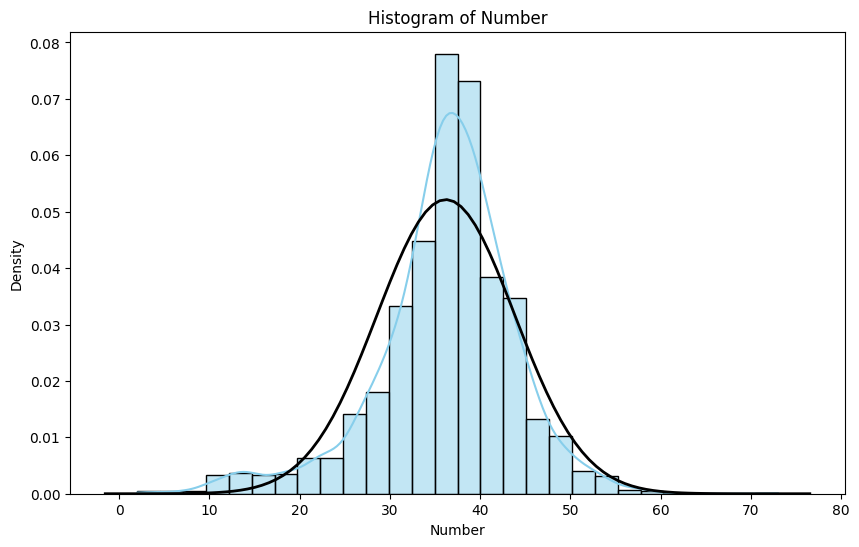

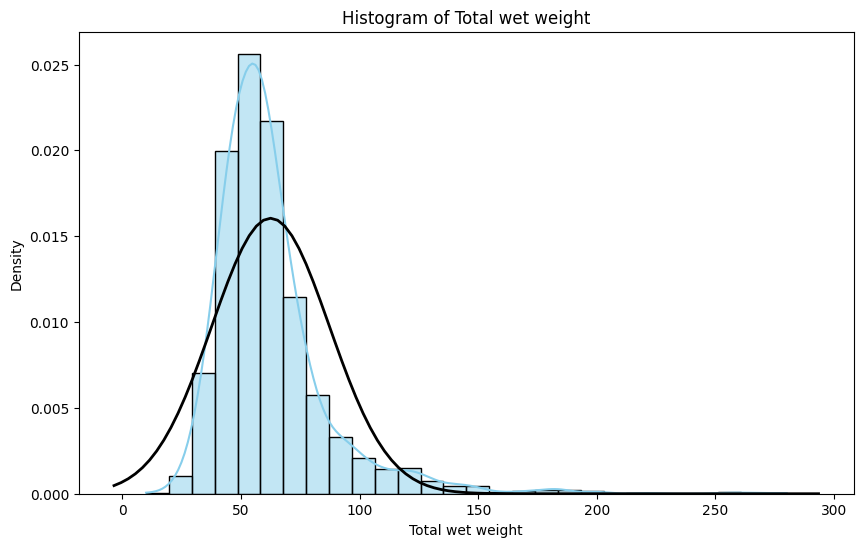

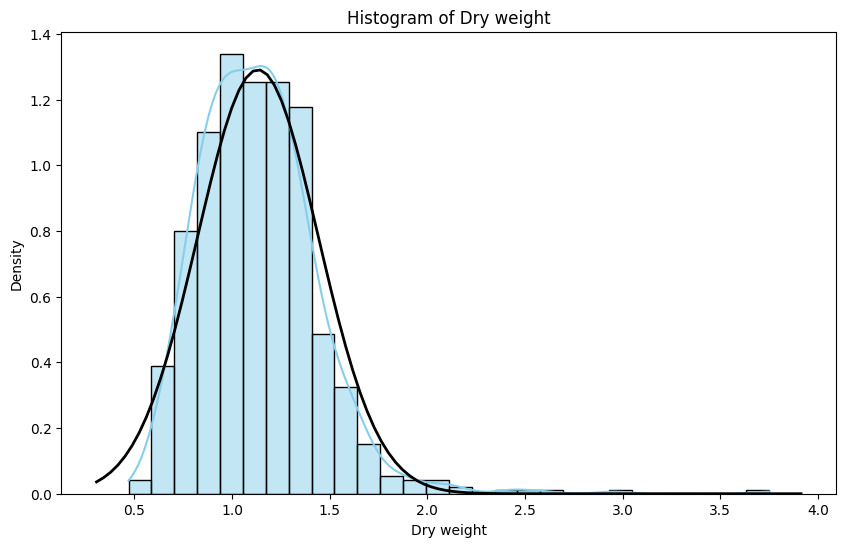

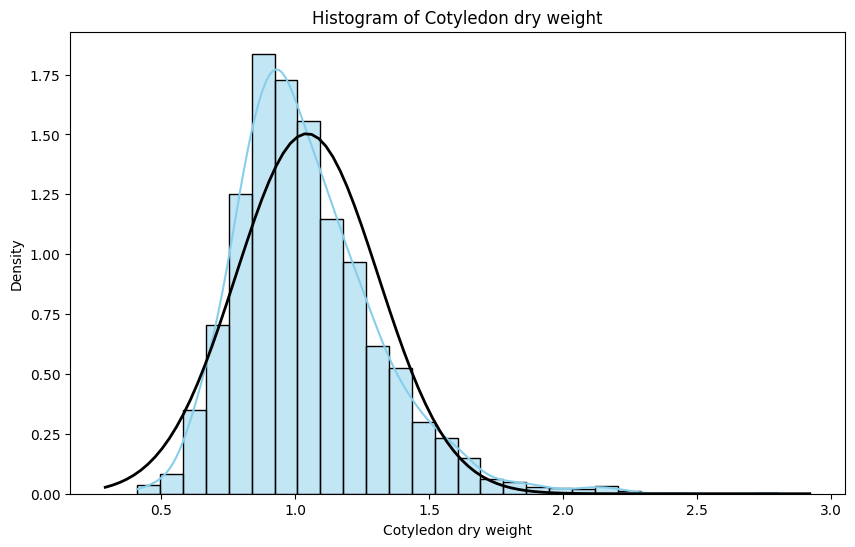

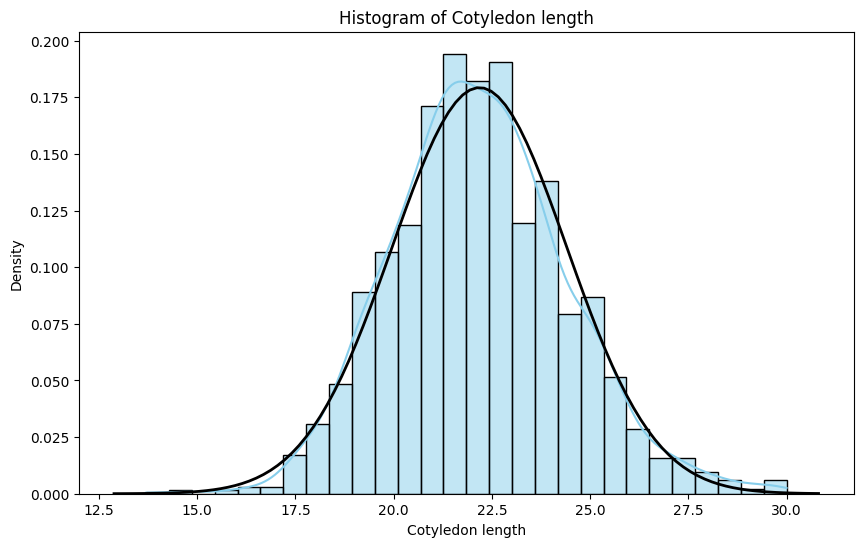

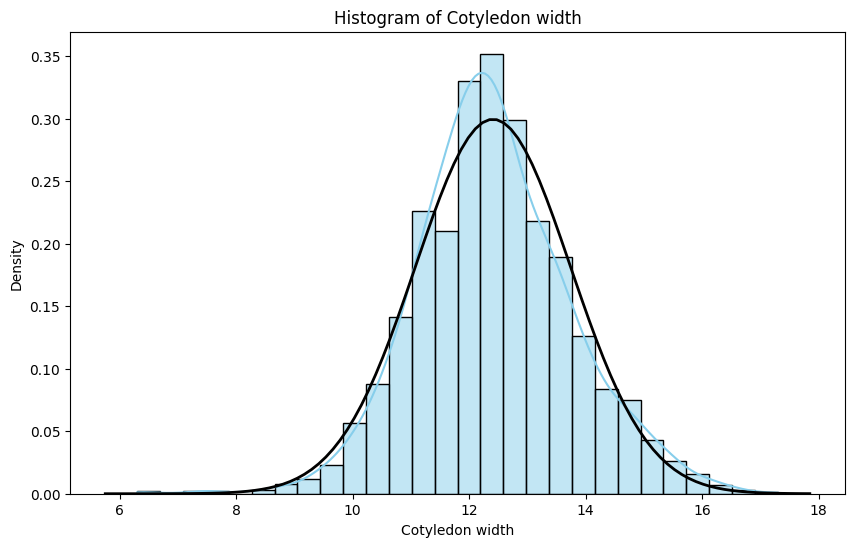

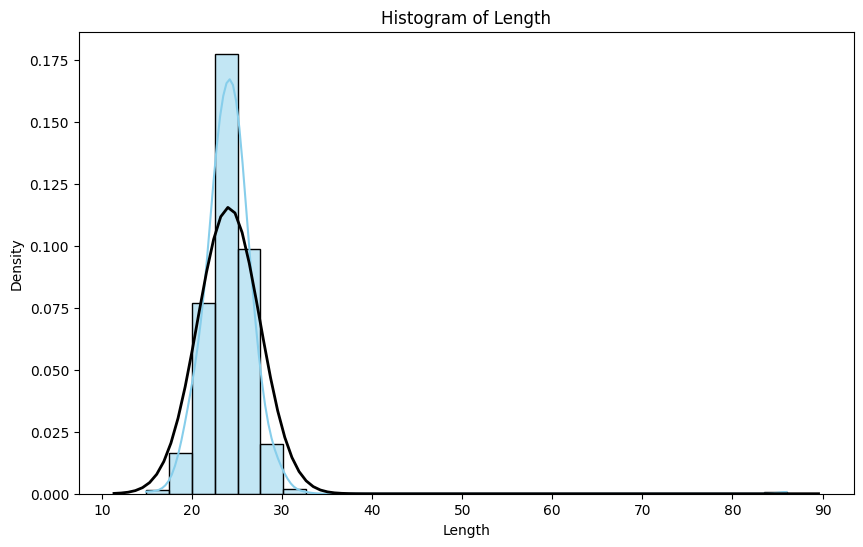

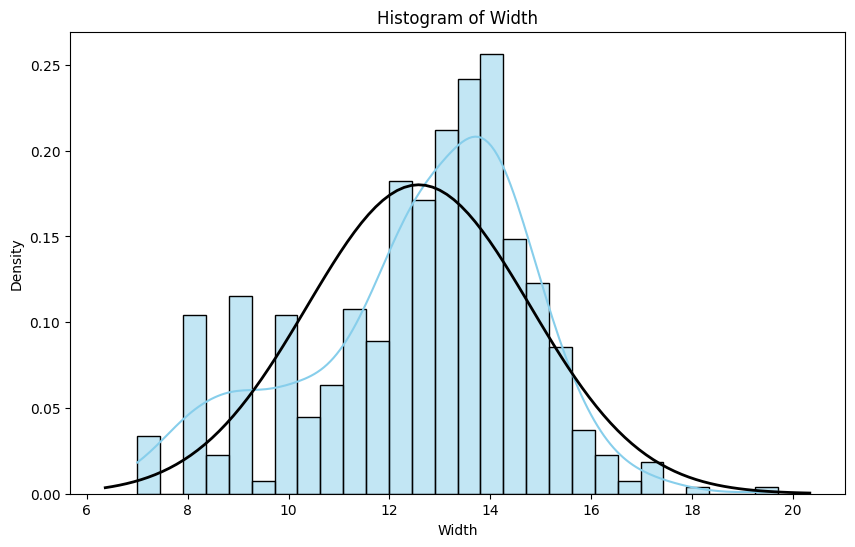

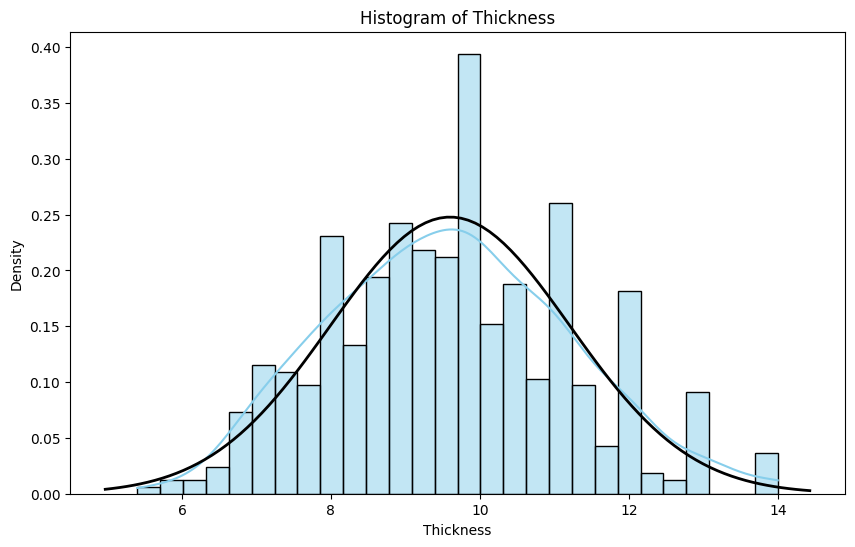

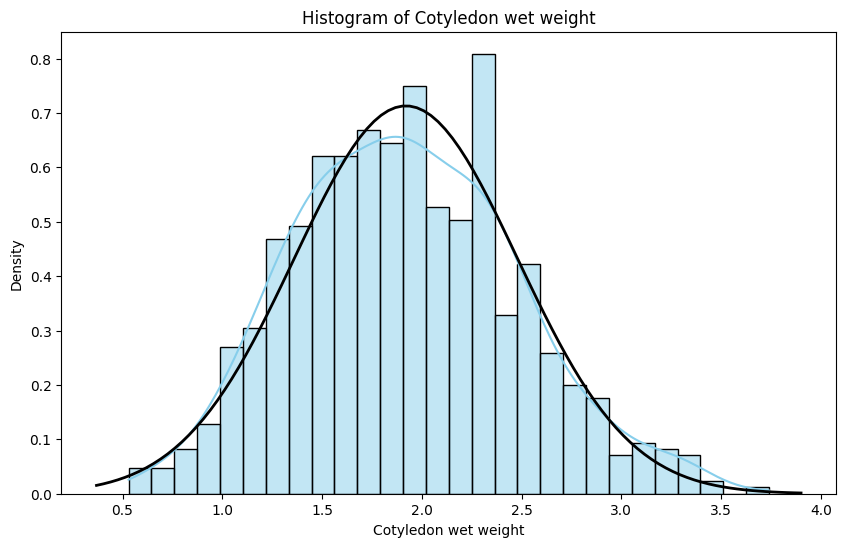

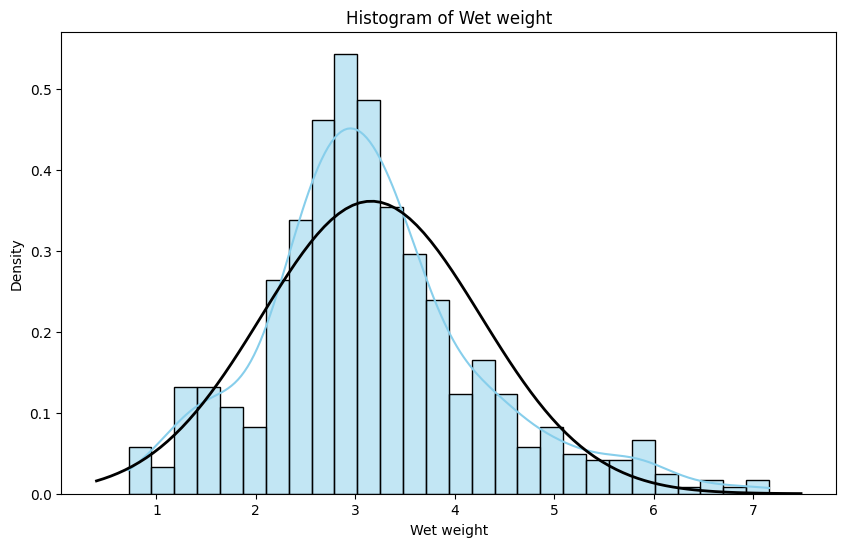

In [ ]:
#Displaying the distribution of each column and checking if it follows a normal distribution
for col in df.select_dtypes(include='number'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, stat='density', color='skyblue', bins=28)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    # Add a normal distribution line if you suspect normal distribution
    mu, std = norm.fit(df[col].dropna())
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number                4562 non-null   float64
 1   Total wet weight      4562 non-null   float64
 2   Dry weight            4562 non-null   float64
 3   Cotyledon dry weight  4562 non-null   float64
 4   Cotyledon length      4562 non-null   float64
 5   Cotyledon width       4562 non-null   float64
 6   Colour purple         1226 non-null   object 
 7   Colour light purple   1180 non-null   object 
 8   Colour white          4562 non-null   object 
 9   Colour mottled        493 non-null    object 
 10  Shape                 2187 non-null   object 
 11  Length                4562 non-null   float64
 12  Width                 4562 non-null   float64
 13  Thickness             4562 non-null   float64
 14  Cotyledon wet weight  4562 non-null   float64
 15  Wet weight           

**(Option) to replace missing values by IQR**

**Showing the Probability of values in Shape column**

**Note: The elliptic form appears more frequently in the data than any other form.**

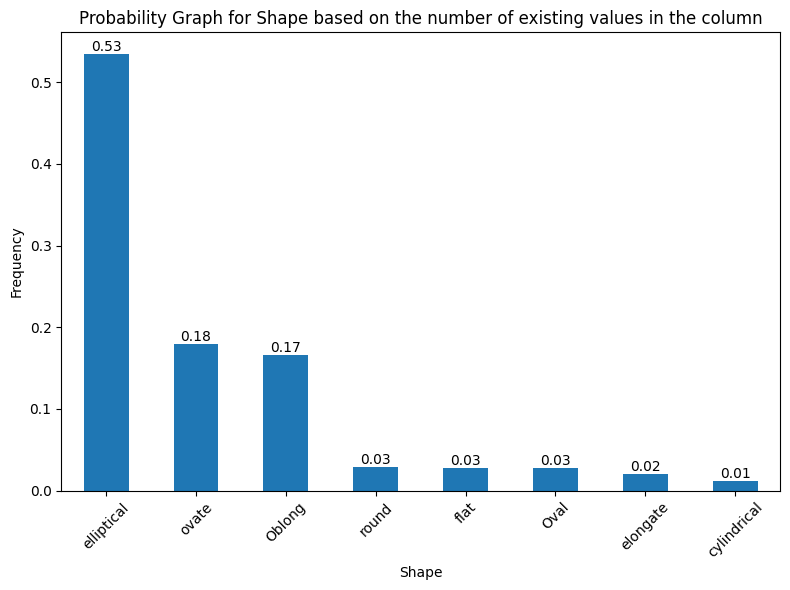

In [ ]:
#ploting Bar Char for Probability of Shap (Filtering out all values that are smaller than 1%):
plote_bar_char_with_labels('Shape',df)

In [ ]:
#Understanding how much data is missing
#Colour light purple:
print('Missing Values Nan:!')
print('Colour light purple:')
print(df['Colour light purple'].isnull().sum()/len(df))
print('Colour dark purple:')
print(df['Colour dark purple'].isnull().sum()/len(df))
print('Colour purple:')
print(df['Colour purple'].isnull().sum()/len(df))
print('Colour white')
print(df['Colour white'].isnull().sum()/len(df))
print('Colour mottled')
print(df['Colour mottled'].isnull().sum()/len(df))
print('Colour grey')
print(df['Colour grey'].isnull().sum()/len(df))
print('Colour Pink')
print(df['Colour pink'].isnull().sum()/len(df))

Missing Values Nan:!
Colour light purple:
0.741341516878562
Colour dark purple:
0.5
Colour purple:
0.7312582200789127
Colour white
0.0
Colour mottled
0.8919333625602806
Colour grey
0.9355545813239807
Colour Pink
0.0


In [ ]:
#Understanding how many rows exists
print('Numbers of rows:!')
print('Colour light purple:')
print(len(df)-df['Colour light purple'].isnull().sum())
print('Colour dark purple:')
print(len(df)-df['Colour dark purple'].isnull().sum())
print('Colour purple:')
print(len(df)-df['Colour purple'].isnull().sum())
print('Colour white')
print(len(df)-df['Colour white'].isnull().sum())
print('Colour mottled')
print(len(df)-df['Colour mottled'].isnull().sum())
print('Colour grey')
print(len(df)-df['Colour grey'].isnull().sum())
print('Colour Pink')
print(len(df)-df['Colour pink'].isnull().sum())
print()
print(len(df))

Numbers of rows:!
Colour light purple:
1180
Colour dark purple:
2281
Colour purple:
1226
Colour white
4562
Colour mottled
493
Colour grey
294
Colour Pink
4562

4562


**Showing the Probability of values in Colors columns**

**Note:The Colour dark purple appears more frequently in the data than any other form.**

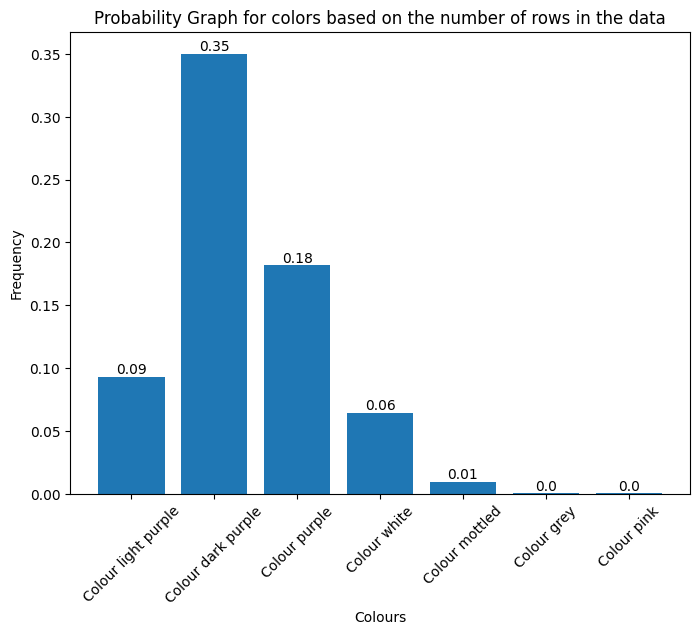

In [ ]:
#showing the Real probability for colours
colours=['Colour light purple','Colour dark purple','Colour purple','Colour white','Colour mottled','Colour grey','Colour pink']
#create probability for columns
precent_bar=[]
for column in colours:
  precent_bar.append(df[column].value_counts()['+']/len(df))
plt.figure(figsize=(8, 6))
plt.bar(colours, precent_bar)
for index, value in enumerate(precent_bar):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.xlabel('Colours')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Probability Graph for colors based on the number of rows in the data')

# Displaying the plot
plt.show()


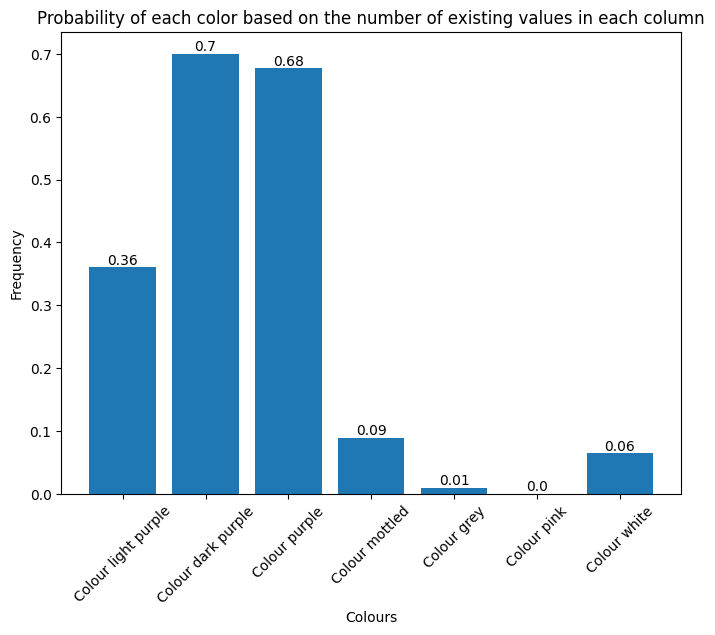

In [ ]:
#Probability of each color based on the number of existing values in each column .
#showing the Real probability for colours
colours=['Colour light purple','Colour dark purple','Colour purple','Colour mottled','Colour grey','Colour pink','Colour white']
#create probability for columns
precent_bar=[]
for column in colours:
  precent_bar.append(df[column].value_counts()['+']/df[column].value_counts().sum())
plt.figure(figsize=(8, 6))
plt.bar(colours, precent_bar)
for index, value in enumerate(precent_bar):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.xlabel('Colours')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Probability of each color based on the number of existing values in each column')

# Displaying the plot
plt.show()

**Identifying whether there is an unnecessary column in the color section**

In [ ]:
for column in colours:
  print(column,':\n',df[column].value_counts(),'\n')

Colour light purple :
 -    755
+    425
Name: Colour light purple, dtype: int64 

Colour dark purple :
 +    1596
-     685
Name: Colour dark purple, dtype: int64 

Colour purple :
 +    830
-    396
Name: Colour purple, dtype: int64 

Colour mottled :
 -    449
+     44
Name: Colour mottled, dtype: int64 

Colour grey :
 -    291
+      3
Name: Colour grey, dtype: int64 

Colour pink :
 -    4560
+       2
Name: Colour pink, dtype: int64 

Colour white :
 -    4267
+     295
Name: Colour white, dtype: int64 



**Replacing all unnecessary columns with a new category (other).**

In [26]:
#replacing the categories 'pink,' 'grey,' and( 'mottled' with the category 'other'."
cnd_other=(df['Colour mottled']=='+')|(df['Colour grey']=='+')|(df['Colour pink']=='+')
df['Other_Colour']=np.where(cnd_other,'+','-')

In [ ]:
print(df['Other_Colour'].value_counts())


-    4514
+      48
Name: Other_Colour, dtype: int64


**Displaying the probability distribution of values in the Colors columns, including the new category**

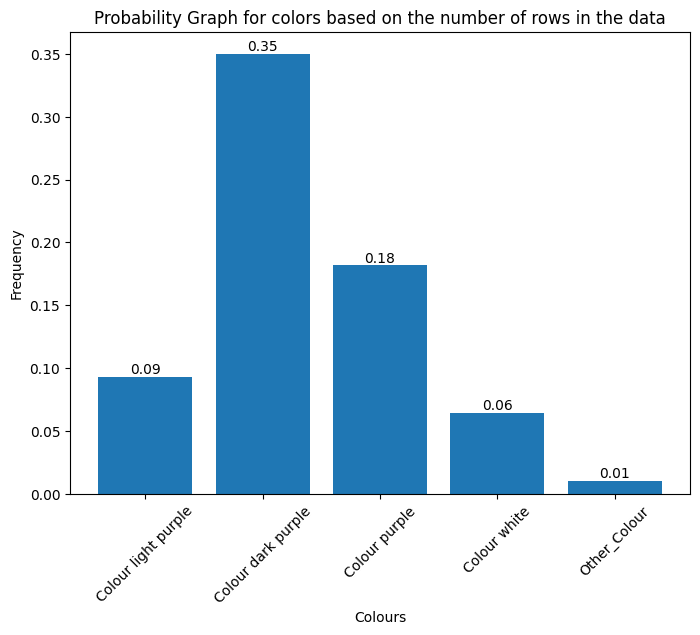

In [ ]:
#showing the Real probability for colours
colours=['Colour light purple','Colour dark purple','Colour purple','Colour white','Other_Colour']
#create probability for columns
precent_bar=[]
for column in colours:
  precent_bar.append(df[column].value_counts()['+']/len(df))
plt.figure(figsize=(8, 6))
plt.bar(colours, precent_bar)
for index, value in enumerate(precent_bar):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.xlabel('Colours')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Probability Graph for colors based on the number of rows in the data')

# Displaying the plot
plt.show()

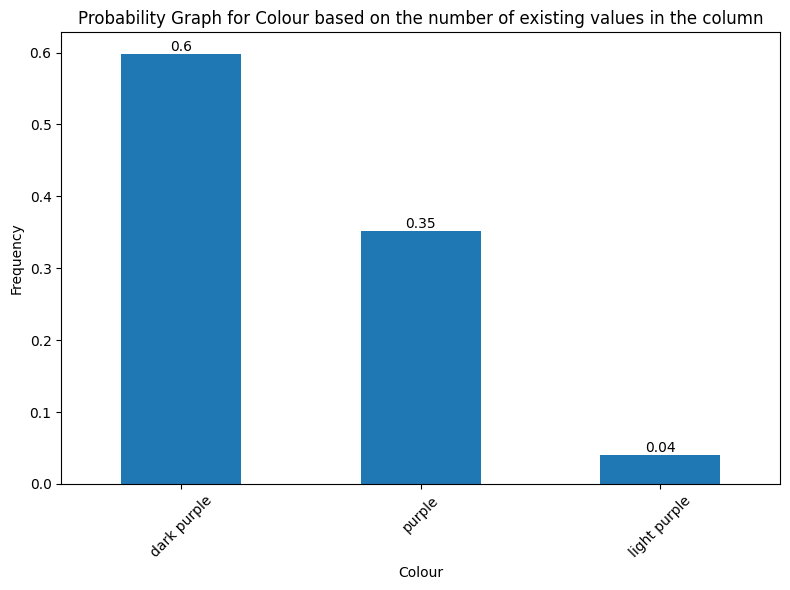

In [ ]:
plote_bar_char_with_labels('Colour',df)

**writing the data with missing values to excel** 

In [ ]:
df[['Clone name + Refcode','Number','Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight','Shape',' Colour']].to_csv('bean_data_V2.csv', index=False)

# **Step 2 - Analyze the Beans table**

# Exploring Correlations: Features Related to the 'Number' Attribute

In [ ]:
# Number,Cotyledon dry weight,Cotyledon length,Cotyledon width,Shape,Colour,Total wet weight

# Do cotyledon characteristics and wet weight (dry weight, length, width) influence the number of beans produced?

# **correlation matrix**

# Person

In [27]:
#import libraries
import plotly.express as px

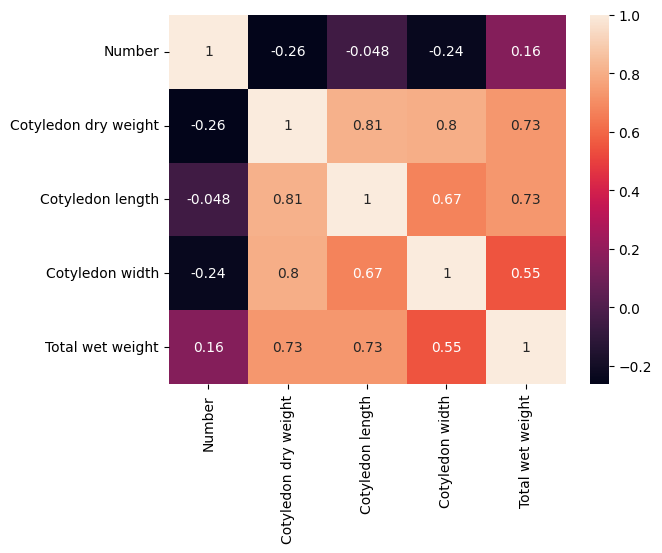

In [ ]:
#plotting the heatmap for correlation
analyze_columns=['Number','Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight']
ax = sns.heatmap(df[analyze_columns].corr(), annot=True)

# Spearman

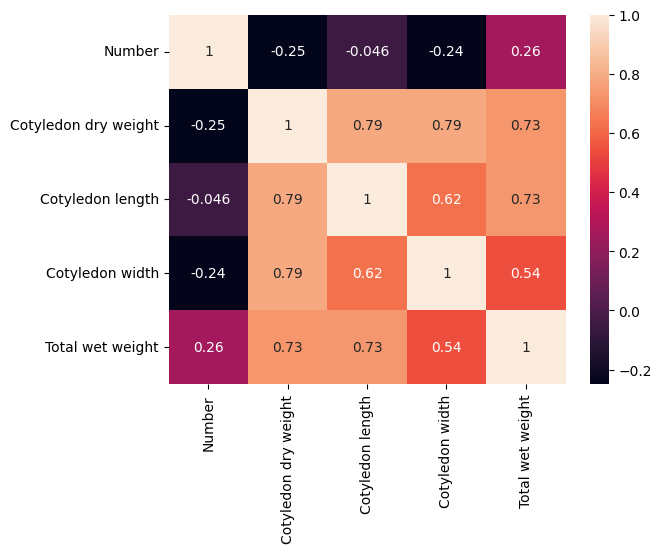

In [ ]:
#plotting the heatmap for correlation
analyze_columns=['Number','Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight']
ax = sns.heatmap(df[analyze_columns].corr(method='spearman'), annot=True)

<Figure size 640x480 with 0 Axes>

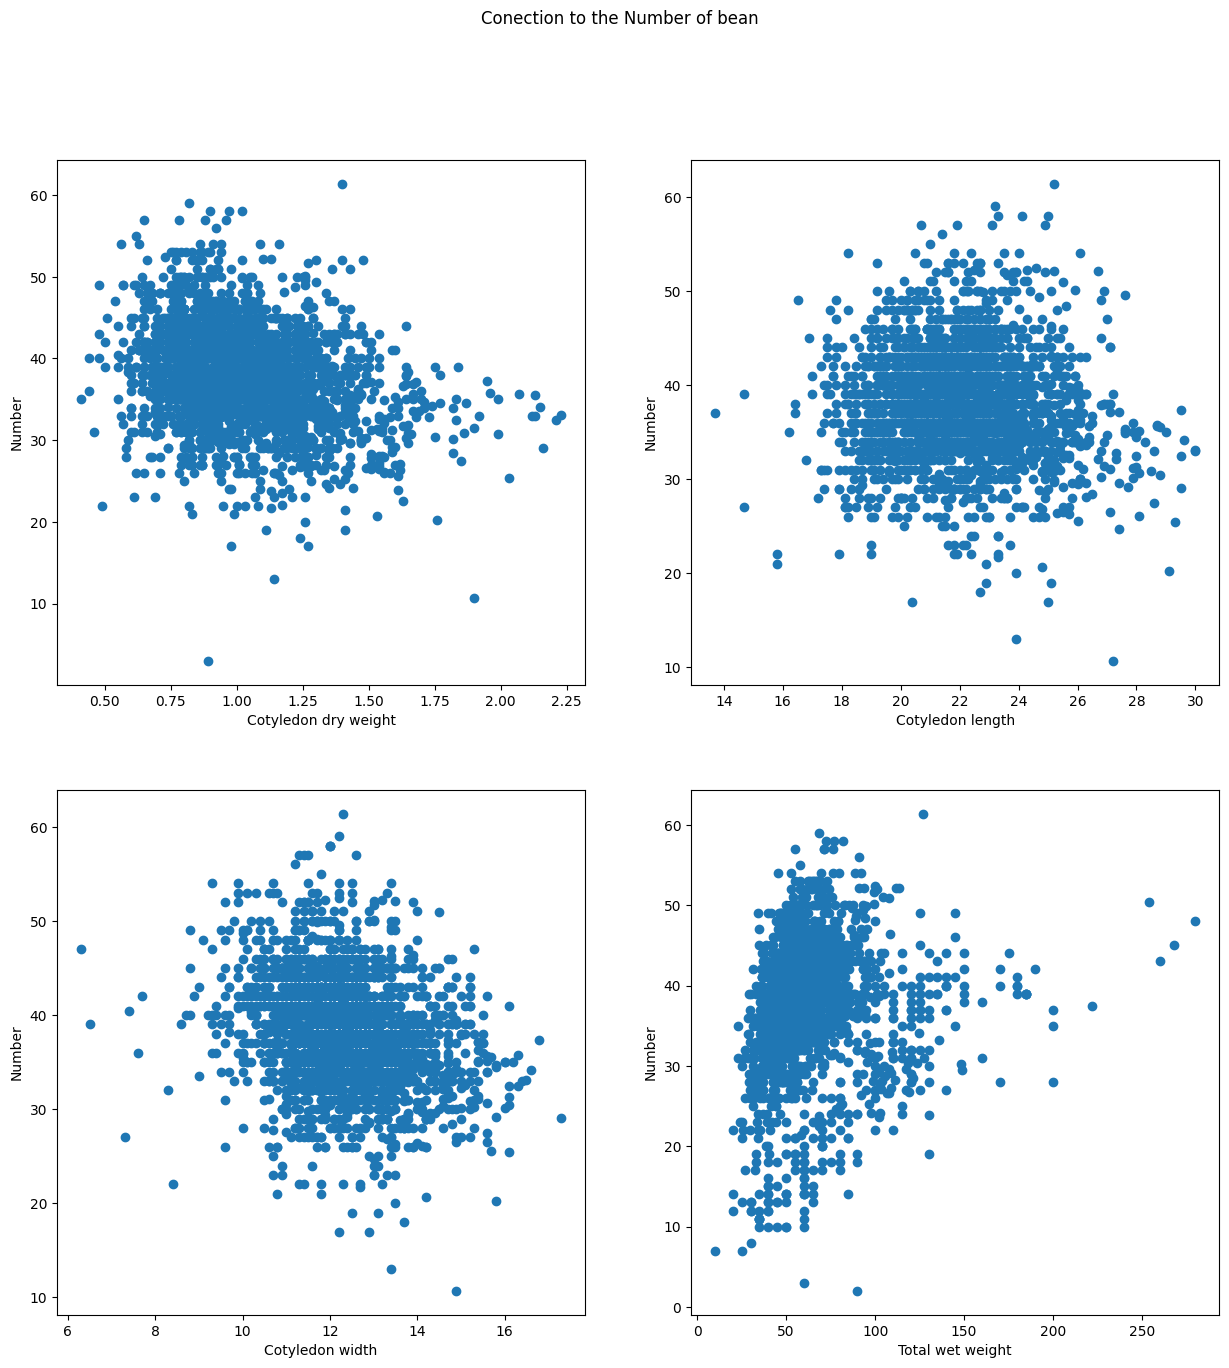

In [ ]:
analyze_columns=['Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight']
plt.suptitle('Conection to the Number of bean')
plt.figure(figsize=(15, 15))
plt.suptitle('Conection to the Number of bean')
for index,x_axis in enumerate(analyze_columns):
  plt.subplot(2,2,index+1)
  plt.xlabel(x_axis)
  plt.ylabel('Number')
  plt.scatter(x=df[x_axis],y=df['Number'])

# Let's examine the relationship between the characteristics of the cotyledon (length and width) and the total wet weight

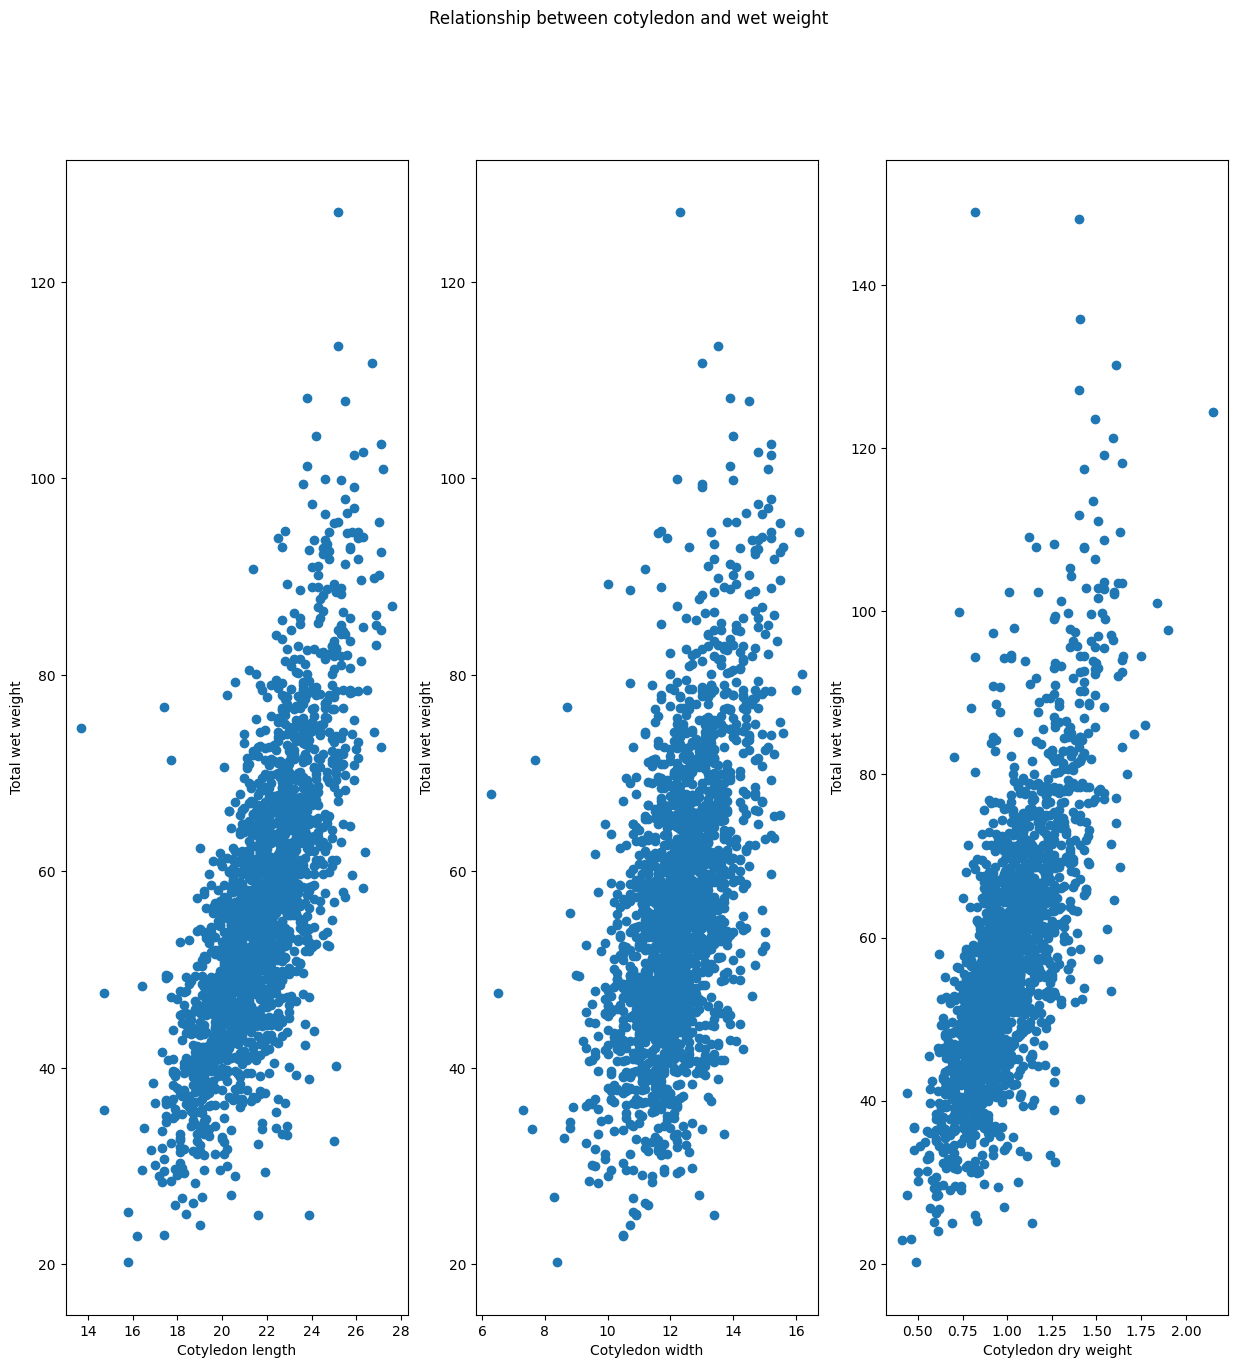

In [ ]:
analyze_columns=['Cotyledon length','Cotyledon width','Cotyledon dry weight']
plt.figure(figsize=(15, 15))
plt.suptitle('Relationship between cotyledon and wet weight')
for index,x_axis in enumerate(analyze_columns):
  plt.subplot(1,3,index+1)
  plt.xlabel(x_axis)
  plt.ylabel('Total wet weight')
  plt.scatter(x=df[x_axis],y=df['Total wet weight'])

# We assume that the numeric columns have a normal distribution according to the graphs we have created.

# **Anova Test**

In [ ]:
def Anova_test(df,category,target):
  # Group numerical data by categories in 'Colour' column
  df_filtered = df.dropna(subset=[target])
  df_filtered=df_filtered.dropna(subset=[category])
  groups = {}
  for sub_category, data in df_filtered.groupby(category)[target]:
    groups[sub_category] = data.values
  # Extract numerical data arrays from the dictionary
  data_arrays = list(groups.values())
  # Perform ANOVA test
  f_statistic, p_value = f_oneway(*data_arrays)
  # Print the results
  print("ANOVA Test Results:")
  print("F-statistic:", f_statistic)
  print("p-value:", p_value)
  # Interpret the results
  if p_value < 0.05:
    print("Reject the null hypothesis. There is significant evidence to suggest that there are differences in the means of 'Number' based on 'Colour'.")
    print()
    print()
    # Perform Tukey HSD test
    tukey_results = pairwise_tukeyhsd(df_filtered[target], df_filtered[category],alpha=0.05)
    # Print the Tukey HSD test results
    print("\nTukey HSD Test Results:")
    print(tukey_results)

  else:
    print("Fail to reject the null hypothesis. There is not enough evidence to suggest that there are differences in the means of 'Number' based on 'Colour'.")


# Are there significant differences in the number of beans produced between beans of different colors?

In [ ]:
Anova_test(df,'Colour','Number')

ANOVA Test Results:
F-statistic: 4.154499401695886
p-value: 0.00015033265674938858
Reject the null hypothesis. There is significant evidence to suggest that there are differences in the means of 'Number' based on 'Colour'.



Tukey HSD Test Results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
Intense purple  dark purple  10.9142 0.1534  -1.7826 23.6111  False
Intense purple         grey     15.0 0.1806  -2.9412 32.9412  False
Intense purple light purple   8.6424 0.4529  -4.1924 21.4771  False
Intense purple      mottled      5.5 0.9622 -10.0376 21.0376  False
Intense purple         pink    15.35 0.1579  -2.5912 33.2912  False
Intense purple       purple  10.2603 0.2178   -2.444 22.9646  False
Intense purple        white      6.6 0.8859  -8.4107 21.6107  False
   dark purple         grey   4.0858 0.9778  -8.6111 16.7826  False
  

# Are there specific bean shapes associated with higher or lower numbers of beans?

# Let's do it on the Shape column(Tokey and anova)

In [ ]:
Anova_test(df,'Shape','Number')

ANOVA Test Results:
F-statistic: 11.451437699536218
p-value: 1.1533464913598015e-17
Reject the null hypothesis. There is significant evidence to suggest that there are differences in the means of 'Number' based on 'Colour'.



Tukey HSD Test Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
     Oblong       Other  -5.9635 0.9087 -18.9303  7.0032  False
     Oblong        Oval   6.3698 0.0012   1.5512 11.1884   True
     Oblong cylindrical   6.5365 0.8501  -6.4303 19.5032  False
     Oblong  elliptical  -0.1514    1.0  -1.2513  0.9486  False
     Oblong    elongate   1.1546 0.9848  -2.1707    4.48  False
     Oblong        flat   3.1976 0.3937  -1.2187  7.6138  False
     Oblong       ovate   2.7235    0.0   1.3913  4.0557   True
     Oblong       plump  10.0365 0.7749  -8.2761 28.3491  False
     Oblong       round   0.9448 0.9999  -4.4

# Understanding the connection between numeric variables and the shape column by displaying a Scatterplot Matrix

<Figure size 1500x1500 with 0 Axes>

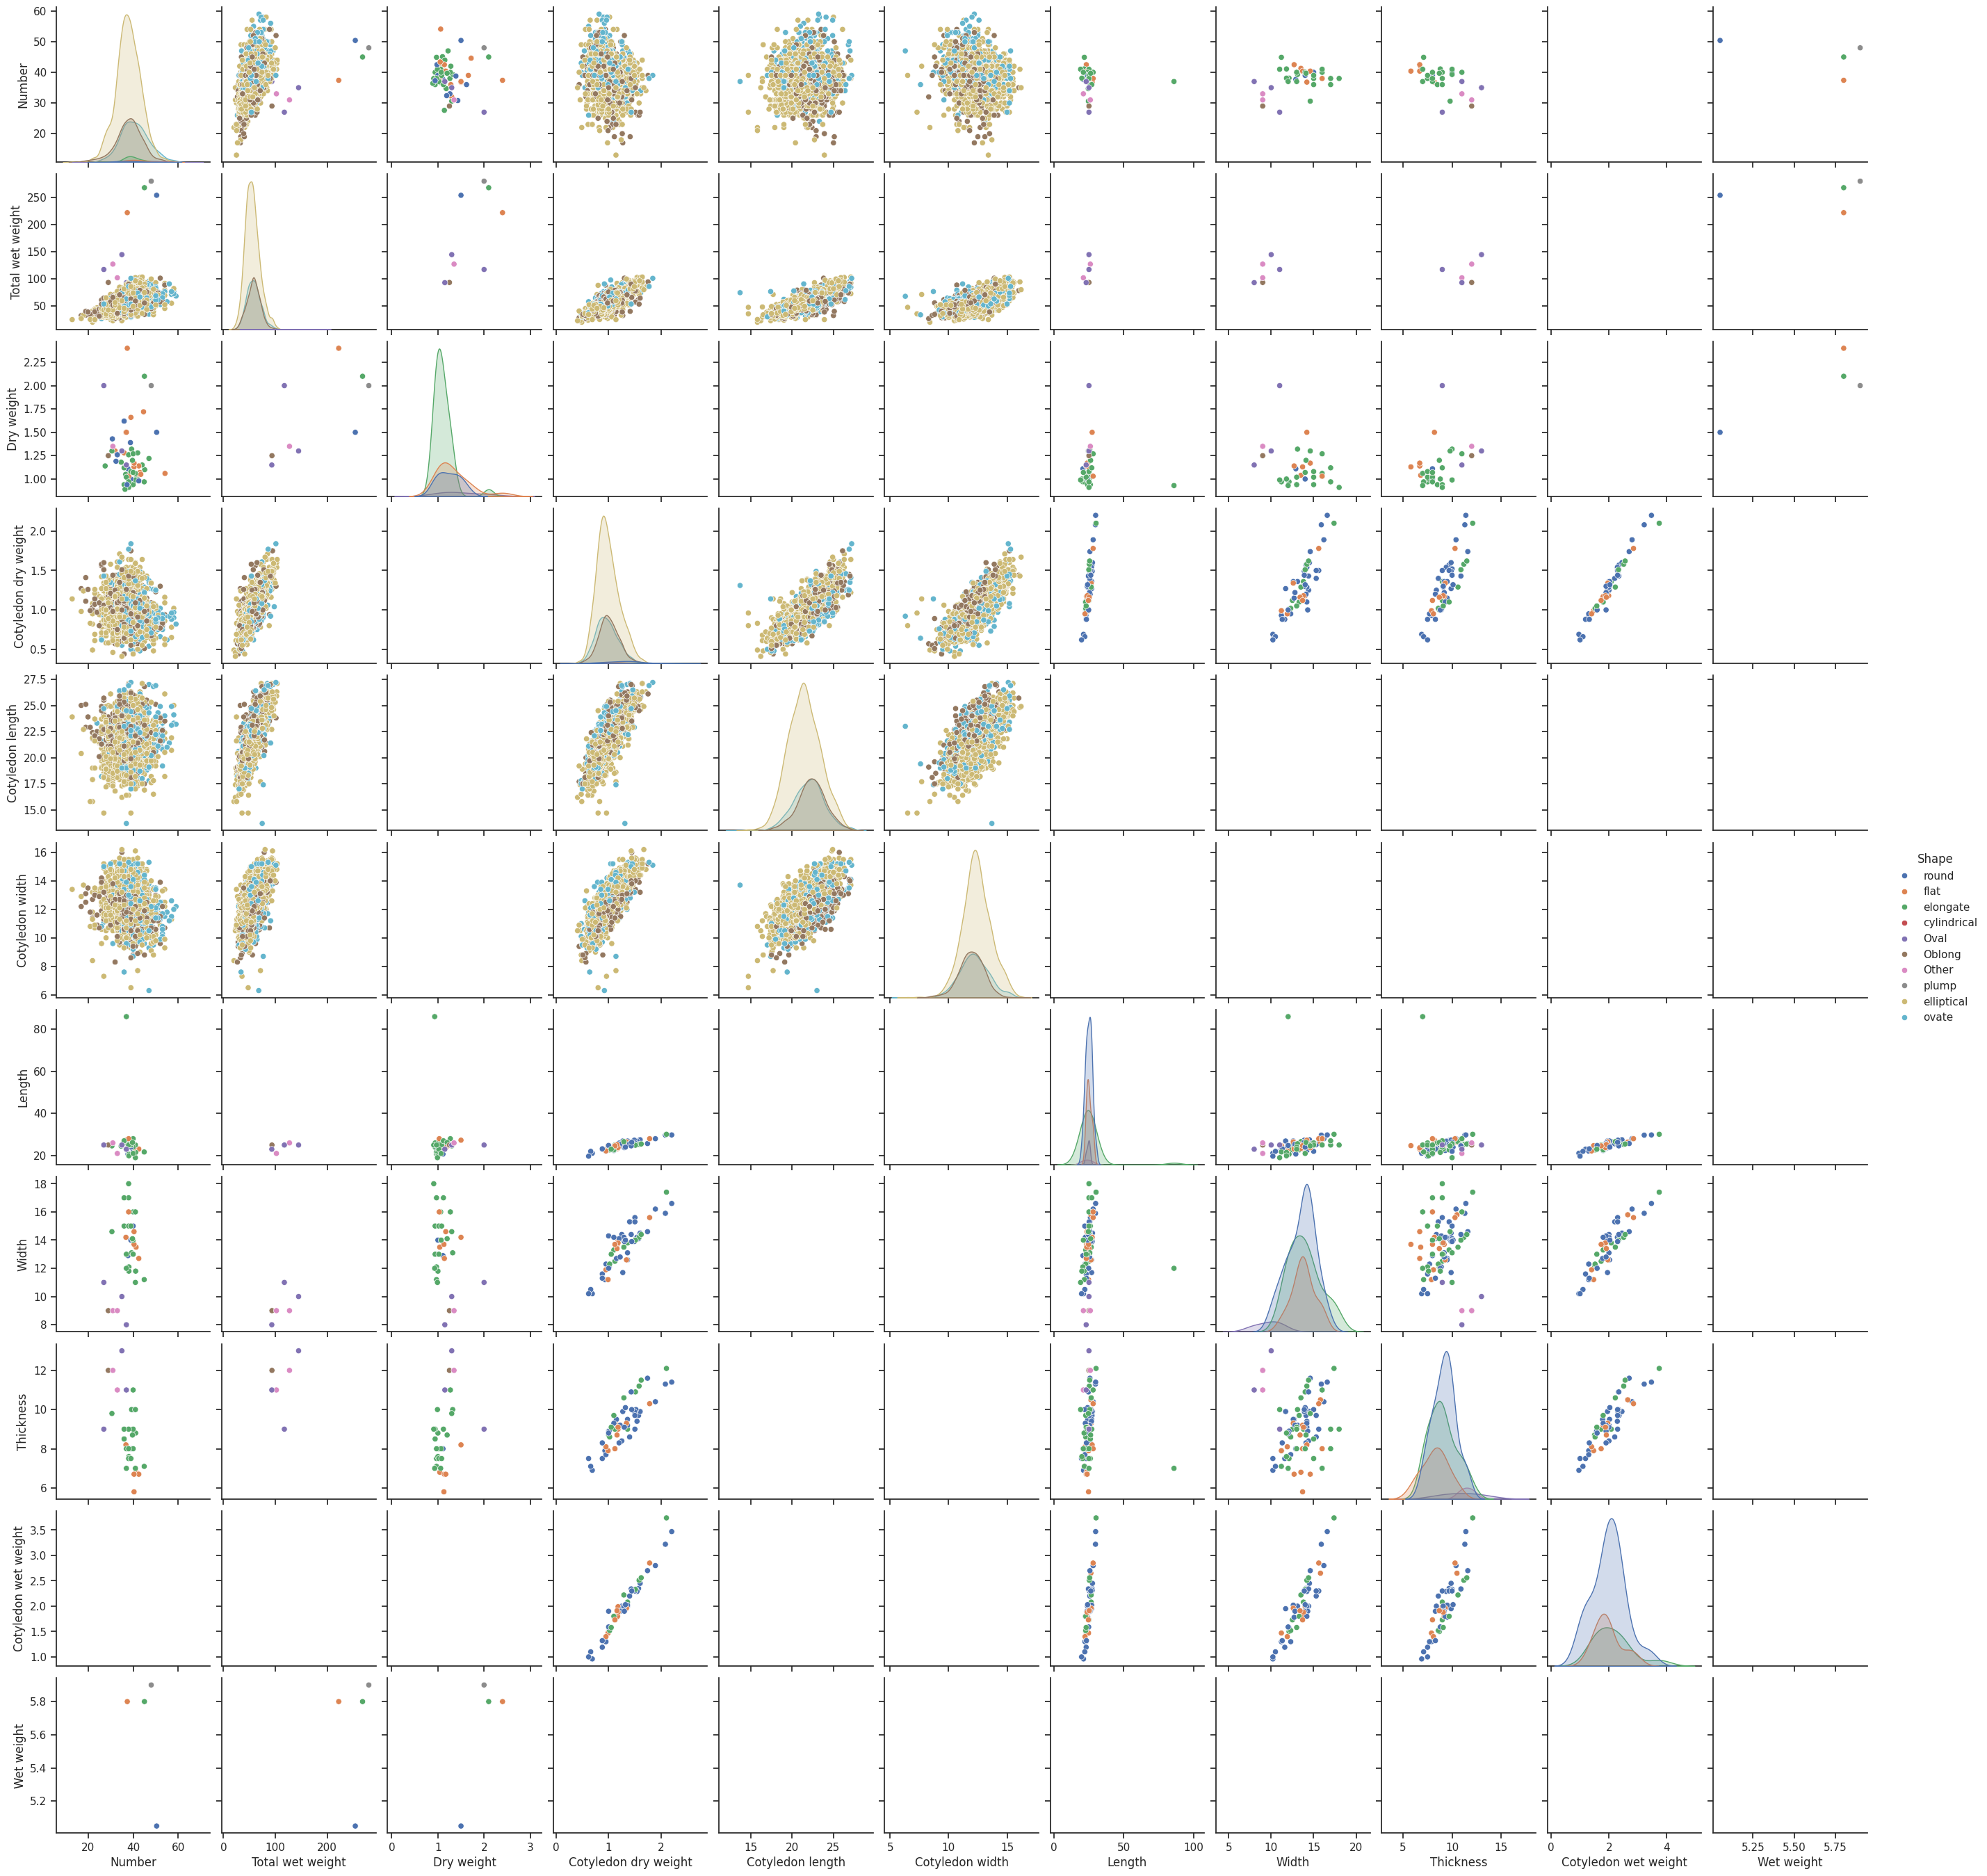

In [ ]:
plt.figure(figsize=(15, 15))
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Shape")

# Let's do the same in the color column

<Figure size 1500x1500 with 0 Axes>

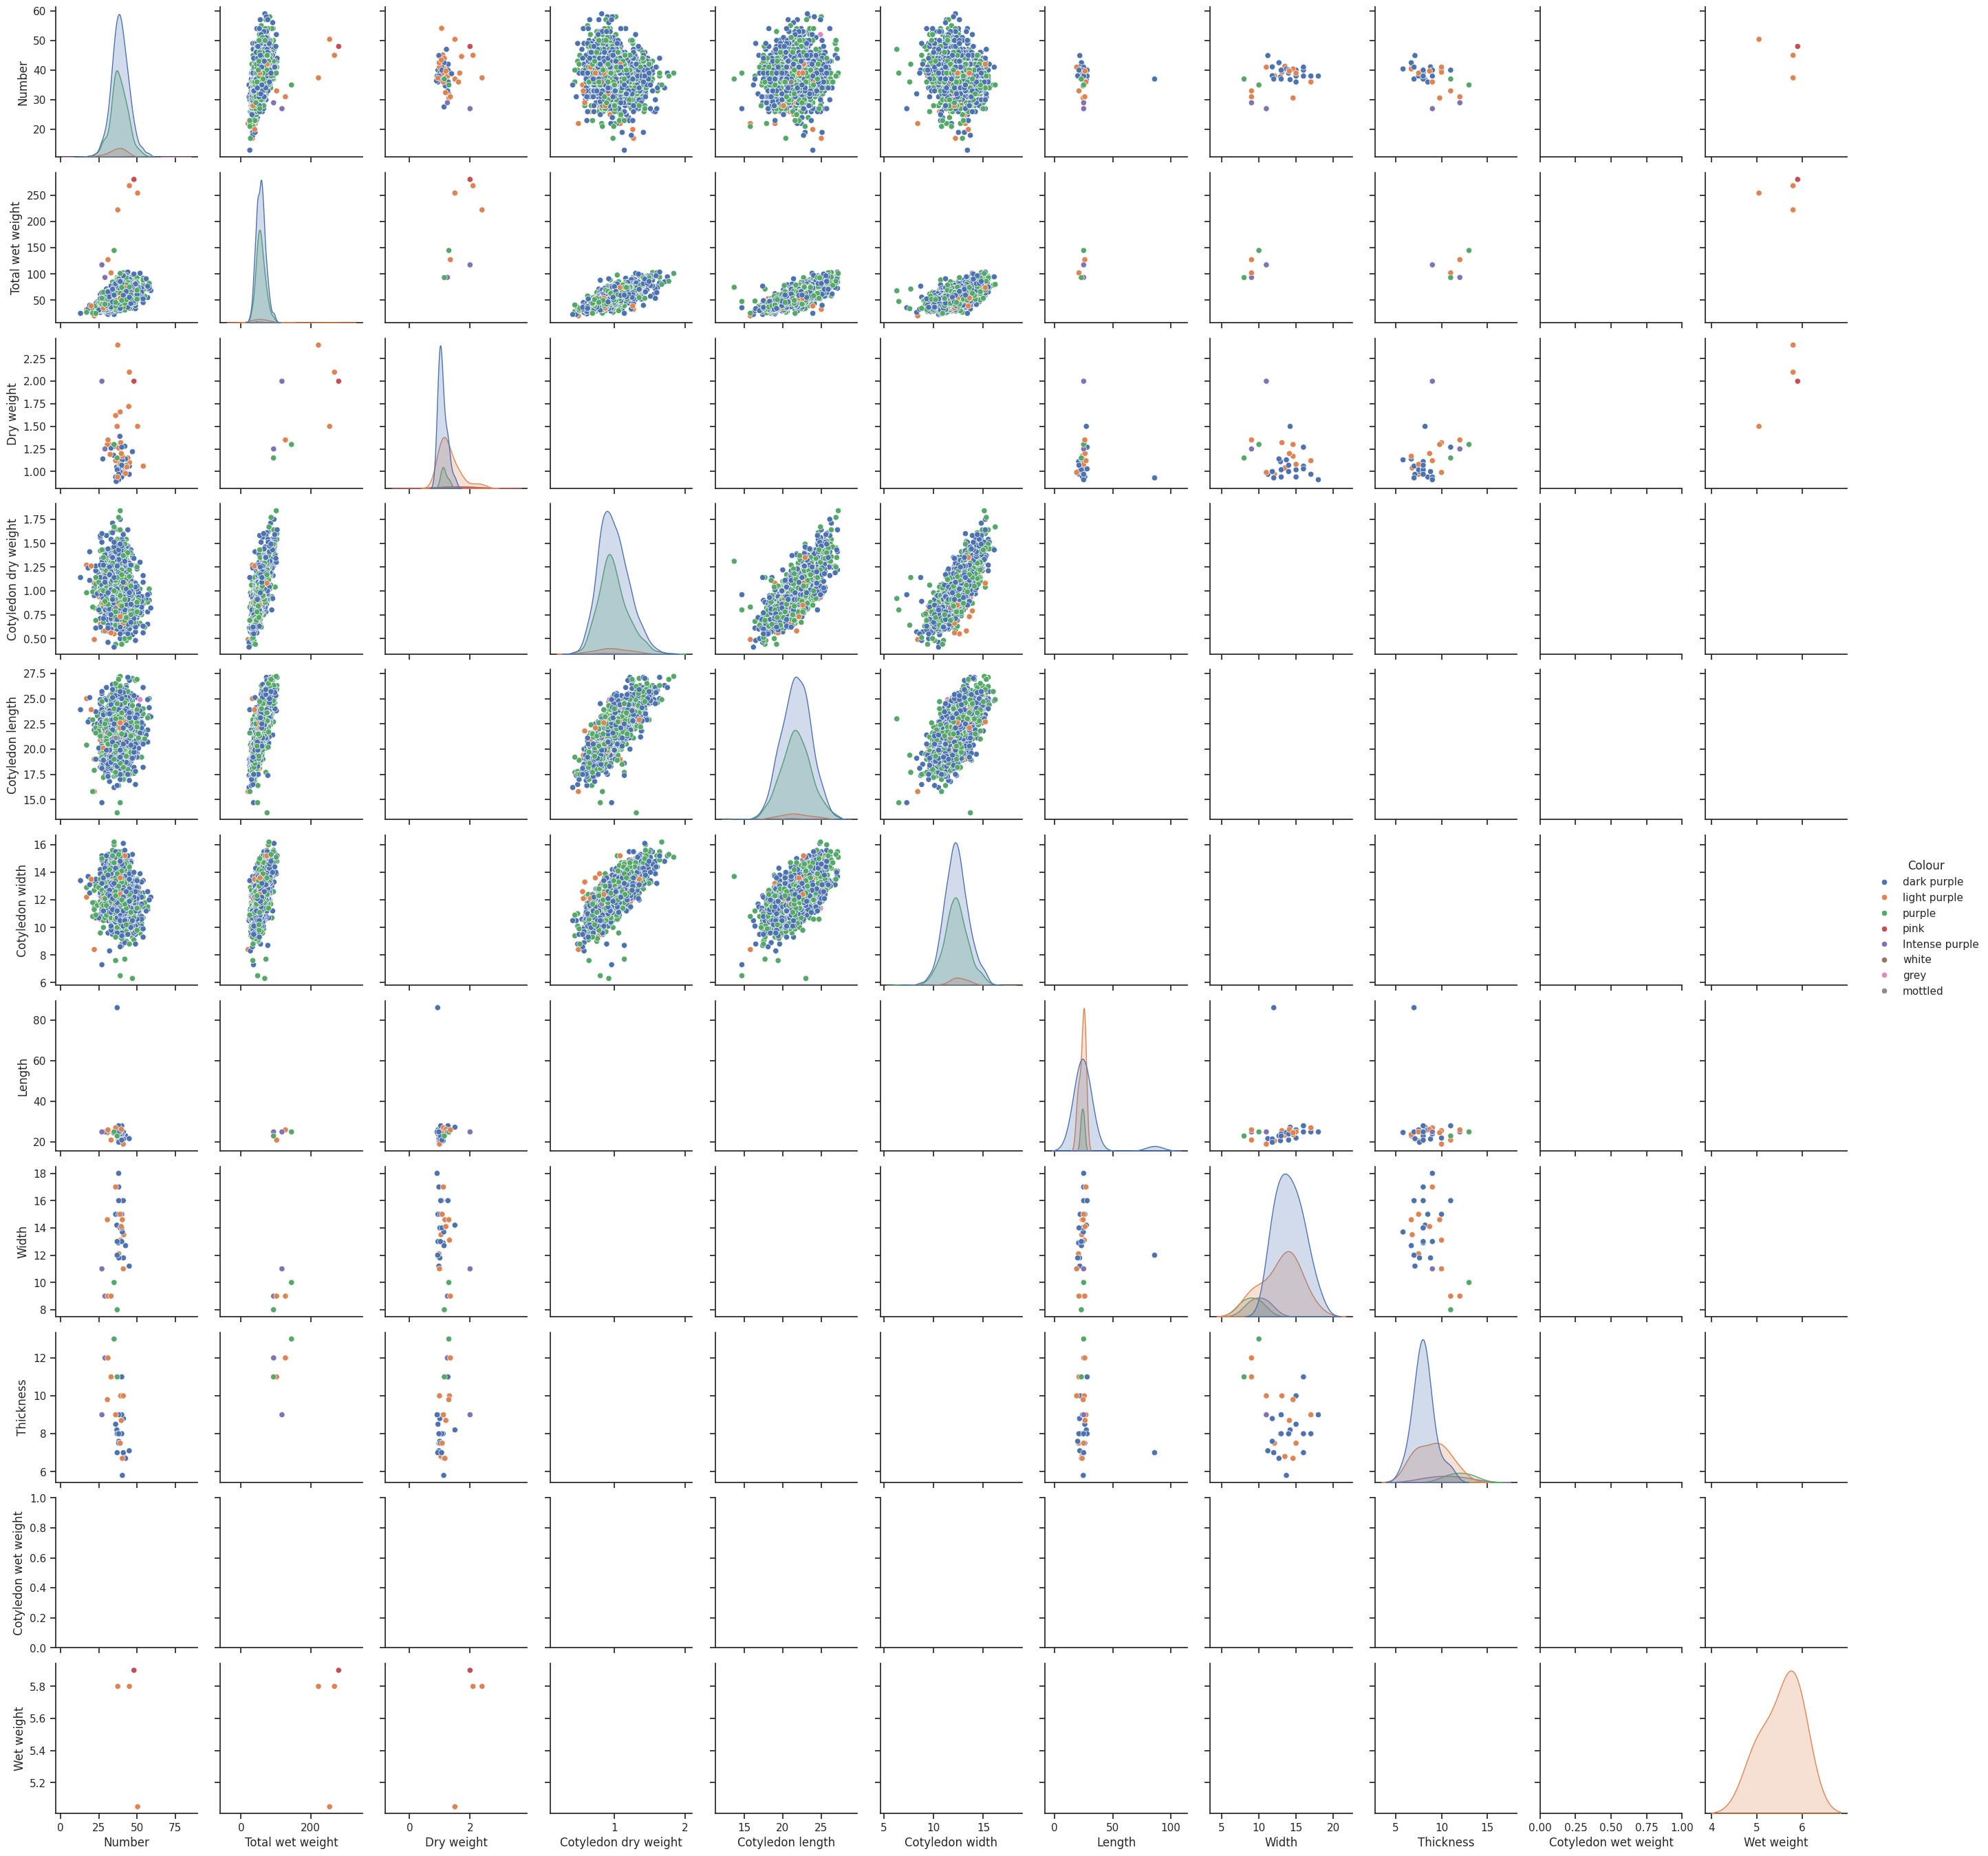

In [ ]:
plt.figure(figsize=(15, 15))
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Colour")

# Displaying the 'number' column with box plots for each color category and shape

In [ ]:
df['Shape'].value_counts()

elliptical     1169
ovate           393
Oblong          362
round            64
flat             60
Oval             60
elongate         44
cylindrical      26
plump             6
Other             3
Name: Shape, dtype: int64

In [ ]:
#Processing the Data for Box Plot Graph
df_boxplote=df.loc[(df['Shape']!='Other')&(df['Shape']!='plump')&(df['Shape']!='cylindrical'),:]

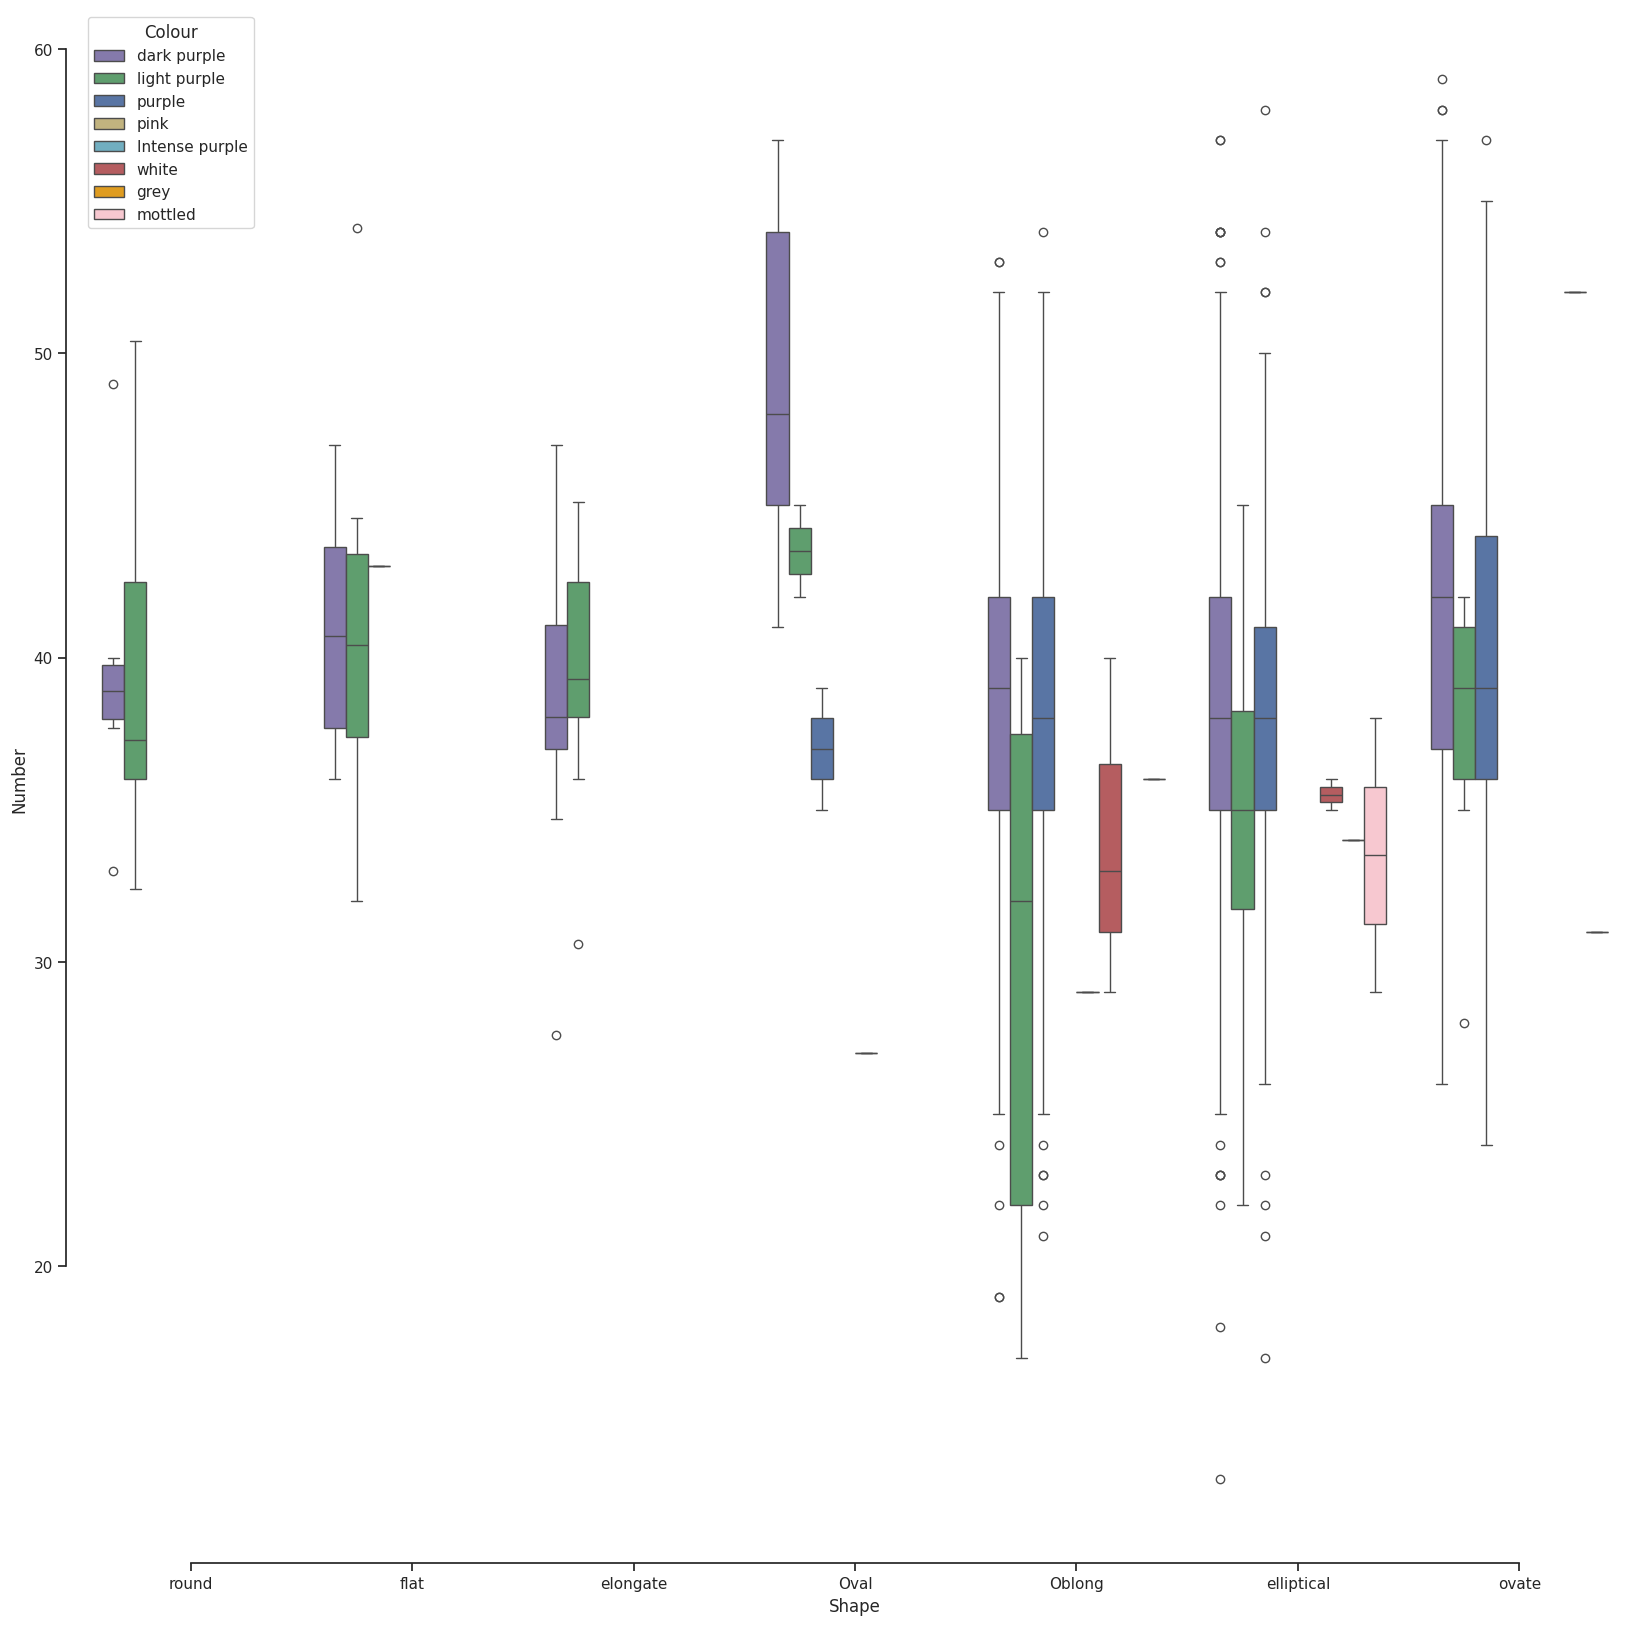

In [ ]:
# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(20, 20))
sns.boxplot(x="Shape", y="Number",
            hue="Colour", palette=["m", "g", "b", "y", "c", "r", "orange", "pink"],
            data=df_boxplote)
sns.despine(offset=10, trim=True)

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


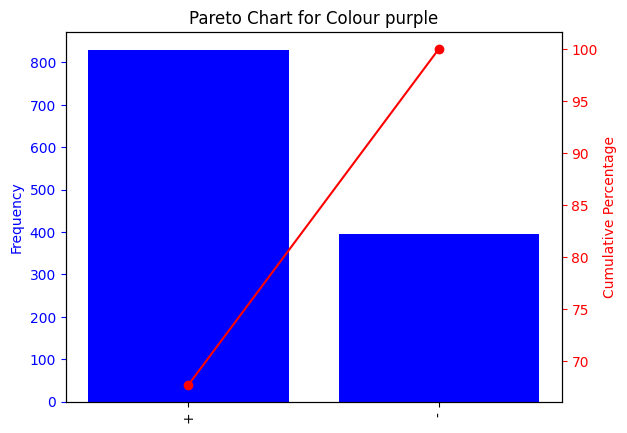

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


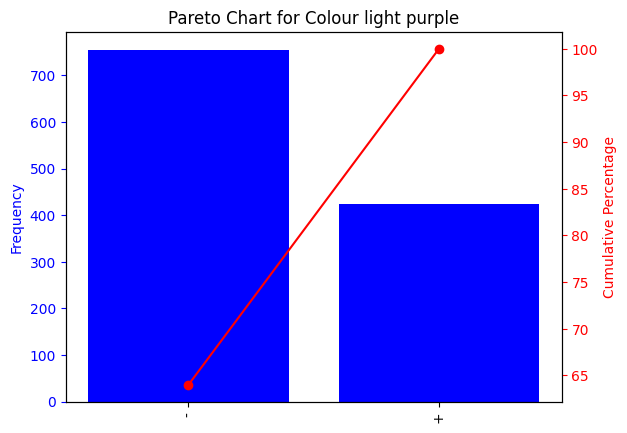

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


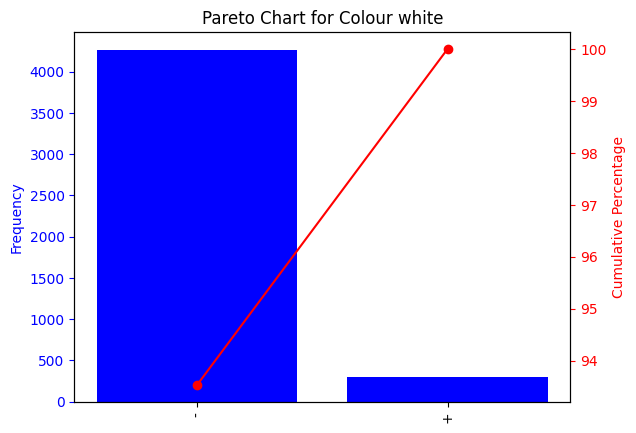

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


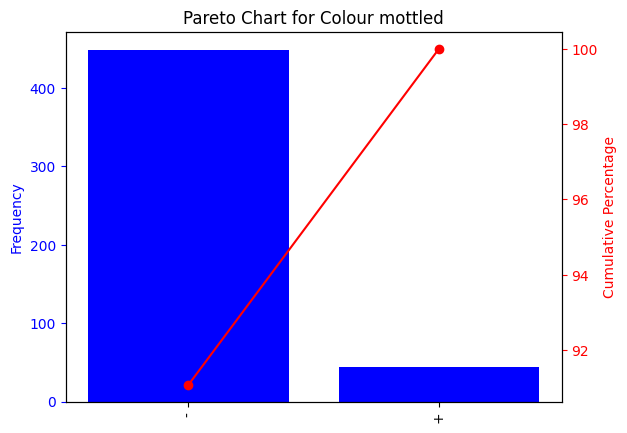

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


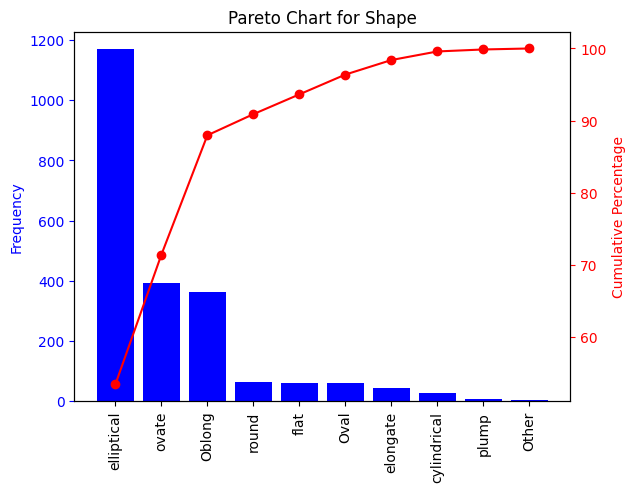

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


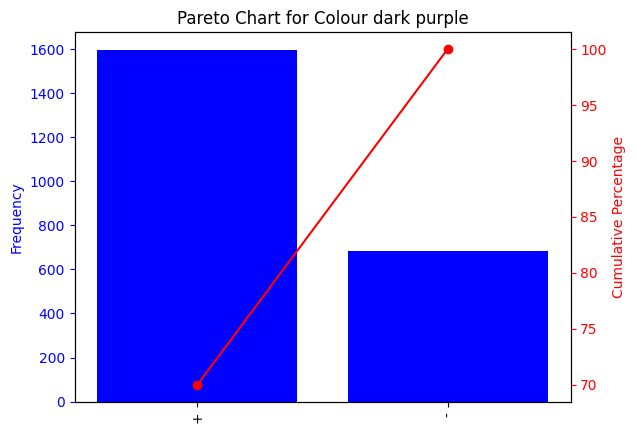

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


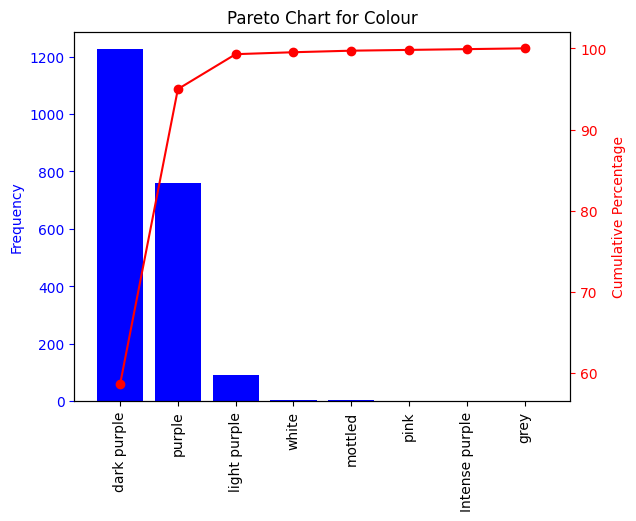

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


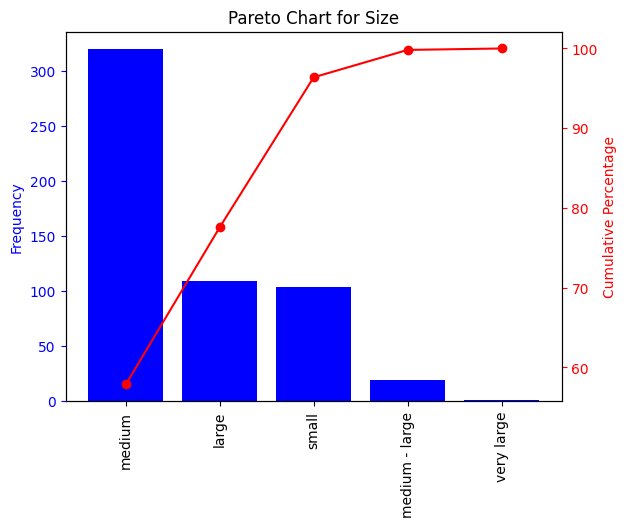

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


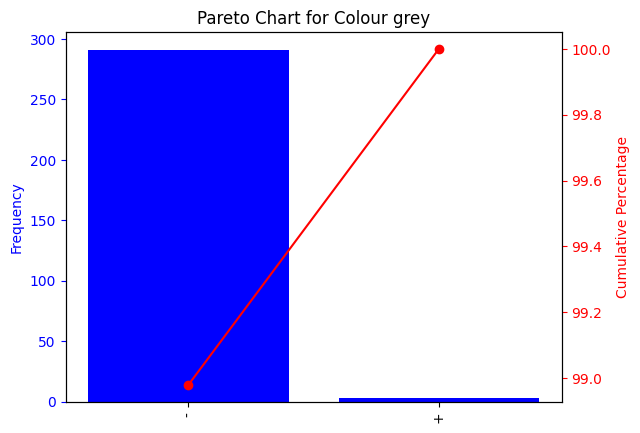

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


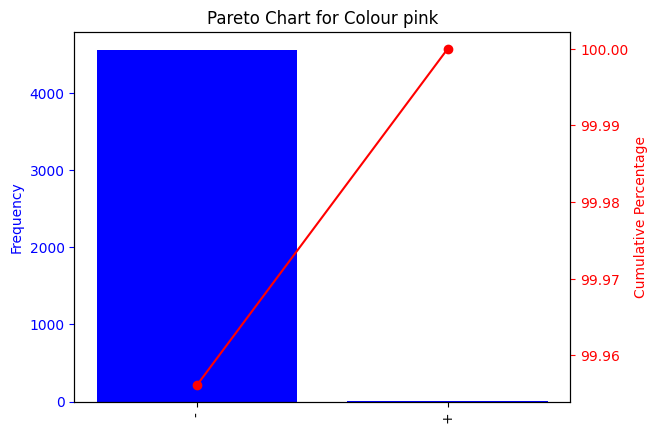

<ipython-input-17-aa2b19166d2b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(counts_sorted.index, rotation=90)  # Rotate x-axis labels for better visibility


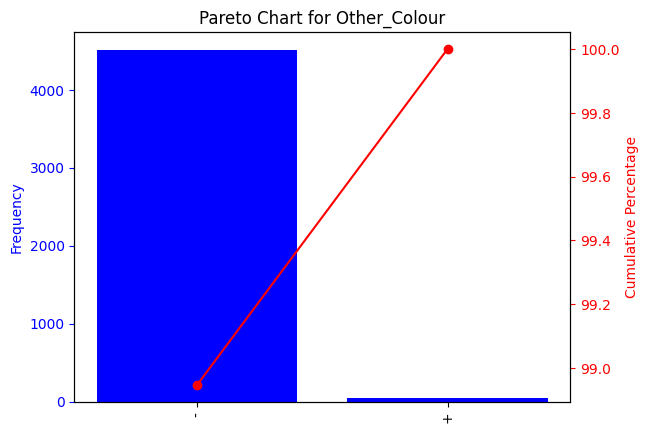

In [35]:
categorical_columns = df.copy()[df.select_dtypes(include='object').columns]
# Exclude specific columns
exclude_columns = ["Info", "Clone name + Refcode",'Notes','Accession']
categorical_columns = [col for col in categorical_columns if col not in exclude_columns]
for category in categorical_columns:
  pareto_chart(df,category)

**Function that delete the duplicate rows**

In [ ]:
def delete_duplicate_rows(df,id_column):
  series_index=df[id_column].value_counts()==1
  series_index=series_index[series_index==1].index
  return df.loc[df[id_column].isin(series_index),:]


In [ ]:
choosing_the_K(df)

In [ ]:
df=clustering_and_replace_missing_values(df,6,['Shape','Colour'])


** writing the full data to excel without missing values**

In [ ]:
df[['Clone name + Refcode','Number','Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight','Shape',' Colour']].to_csv('', df[['Clone name + Refcode','Number','Cotyledon dry weight','Cotyledon length','Cotyledon width','Total wet weight','Shape',' Colour']].to_csv('bean_data_V3.csv', index=False)index=False)